In [7]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize
import pmlb
from scipy.io import loadmat
import h5py
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def load_h5(fname):
    f = h5py.File(fname, 'r')
    data = np.array(f['data'])
    f.close()
    return data

out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'

# for fmri data
X = np.array(loadmat(oj(out_dir, 'mot_energy_feats_st.mat'))['S_fin'])
X_test = np.array(loadmat(oj(out_dir, 'mot_energy_feats_sv.mat'))['S_fin'])

'''
resps_name = oj(out_dir, 'VoxelResponses_subject1.mat')
Y_train = np.array(tables.open_file(resps_name).get_node(f'/rt')[:]) # training responses: 73728 (voxels) x 7200 (timepoints)
Y_test = np.array(tables.open_file(resps_name).get_node(f'/rv')[:]) 
'''

# response
Y_train = load_h5(oj(out_dir, 'rt_norm.h5')) # training responses: 73728 (voxels) x 7200 (timepoints)    
Y_test = load_h5(oj(out_dir, 'rv_norm.h5') )
sigmas = load_h5(oj(out_dir, f'out_rva_sigmas.h5'))
# (U, alphas, _) = pkl.load(open(oj(out_dir, f'decomp_mot_energy.pkl'), 'rb'))


# for mnist data
# dset = 'mnist'
# X, _ = pmlb.fetch_data(dset, return_X_y=True)

In [10]:
print(X.shape, X_test.shape)

(7200, 6555) (540, 6555)


# vary p/n
**looks at how MDL-COMP varies as d/n varies (should keep n fixed)**

In [12]:
def add_results(X_train, X_test, noise_std=0.1, beta_norm=1, d0=50):
    np.random.seed(13)
    n = X_train.shape[0]
    d = X_train.shape[1]    
    beta = np.zeros(d)
    beta[0: d0] = 1
#     beta = np.ones(d) # flat    
#     beta = np.random.randn(d) 
#     beta = np.array([2**(-i) for i in range(d)]) # decay2
    beta = beta / np.linalg.norm(beta) * beta_norm 
    y_train = X_train @ beta + noise_std * np.random.randn(n)
    y_test = X_test @ beta + noise_std * np.random.randn(X_test.shape[0])
    
    u, a, vh = np.linalg.svd(X_train.T @ X_train, full_matrices=True)
    w = vh @ beta
    c = (1 / (2 * X_train.shape[0]))
    logsum = 0
    for i in range(min(n, d)):
        logsum += np.log(1 + a[i] * w[i]**2 / noise_std**2)
    return c * logsum



# X_train_full, X_test_full = train_test_split(X, test_size=10000) # for mnist
X_train_full = X
X_test_full = X_test
n_train_over_num_features_list = np.array([1e-2, 5e-2, 1e-1, 0.5, 0.75, 0.9, 1,
                                  1.2, 1.5, 2, 5, 7.5, 1e1, 2e1, 4e1, 1e2])
n = n_train_over_num_features_list.size
mdl_comps = []
ratios = []
for i, n_train_over_num_features in tqdm(enumerate(n_train_over_num_features_list)):
    n_train_over_num_features = n_train_over_num_features
    
    # vary n
    '''
    num_features = X.shape[1]
    n_train = int(n_train_over_num_features * num_features)
    
    '''
    
    # vary d
    n_train = 100
    d0 = 50
    num_features = int(n_train / n_train_over_num_features)
    
    if n_train < X_train_full.shape[0] and num_features < X_train_full.shape[1] and n_train > 3 and num_features > 3:
        print('shapes', n_train, num_features)
        ratios.append(n_train_over_num_features)
        X_train = X_train_full[:n_train, :num_features]
        X_test = X_test_full[:, :num_features]
        mdl_comps.append(add_results(X_train, X_test, d0=d0))
r = {'mdl_comps': mdl_comps,
     'n_train_over_num_features': n_train_over_num_features_list,
     'ratios': ratios
    }

0it [00:00, ?it/s]

shapes 100 2000


2it [00:05,  2.56s/it]

shapes 100 1000


16it [00:05,  2.73it/s]

shapes 100 200
shapes 100 133
shapes 100 111
shapes 100 100
shapes 100 83
shapes 100 66
shapes 100 50
shapes 100 20
shapes 100 13
shapes 100 10
shapes 100 5


In [20]:
# pkl.dump(r, open(f'intermediate/{dset}_mdl_comps_dstar=20.pkl', 'wb'))

**fig complexity vs d/n**

[1.905076216501342, 1.7776187047622163, 1.189553032498662, 1.0593311621320154, 1.021161797206879, 0.9688901001669287, 0.8500727094224786, 0.7865856621259717, 0.514044632371064, 0.3269739968056982, 0.2476354457874982, 0.2259102962007965, 0.16378838768082216]


/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


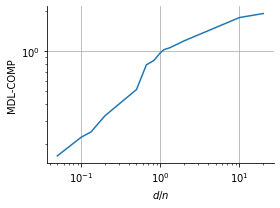

In [13]:
plt.figure(figsize=(4, 3))
# plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
# plt.title('A', fontweight='bold', loc='left')
#         plt.plot(curve.loss_val, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
plt.ylabel('MDL-COMP')
plt.xlabel('$d / n$') #\n(Number of features / Number of training points)')

# r = pkl.load(open(f'intermediate/{dset}_mdl_comps_dstar=20.pkl', 'rb'))
print(r['mdl_comps'])
plt.plot(1/np.array(r['ratios']), r['mdl_comps'], label='Random Gaussian beta')
'''
r = pkl.load(open(f'intermediate/{dset}_mdl_comps.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Random Gaussian beta')
r = pkl.load(open(f'intermediate/{dset}_mdl_comps_flat.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Uniform beta')
r = pkl.load(open(f'intermediate/{dset}_mdl_comps_decay2.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Decay 2')
'''


# plt.legend()


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()
# plt.savefig(oj(save_dir, 'fig_iid_comp.pdf'))